In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/CompPhys/MD/Figures

/content/drive/My Drive/Colab Notebooks/CompPhys/MD/Figures


In [4]:
pwd 

'/content/drive/My Drive/Colab Notebooks/CompPhys/MD/Figures'

In [5]:
%load_ext cython 

In [7]:
%%cython
from cython.view cimport array as cvarray
import numpy as np 
cimport numpy as np 
from libc.math cimport sqrt,ceil
#from scipy.spatial.distance import squareform,pdist
from numpy import array

np.random.seed(10)

cpdef timestep():
  global U
  
  data[:,0]+=data[:,2]*h+0.5*data[:,4]*(h**2)
  data[:,1]+=data[:,3]*h+0.5*data[:,5]*(h**2)

  data[:,2]+=0.5*data[:,4]*h
  data[:,3]+=0.5*data[:,5]*h
  
  U=U_a(data,N,r_c)

  data[:,2]+=0.5*data[:,4]*h
  data[:,3]+=0.5*data[:,5]*h
  
  cross_r=data[:,0]>L
  cross_l=data[:,0]<0
  cross_t=data[:,1]>L
  cross_b=data[:,1]<0
  
  data[cross_r,0]=0
  data[cross_l,0]=L
  data[cross_t,1]=0
  data[cross_b,1]=L

  #data[cross_r|cross_l,2]*=-1
  #data[cross_t|cross_b,3]*=-1

cpdef initialize(int N,float L,int d,float v):

  data=np.zeros((N,d*3),dtype='double')
  cdef int N_x=int(sqrt(N/2))
  cdef int N_y=int(ceil(N/N_x))
  
  x = np.linspace(1,(L/2), N_x)
  y = np.linspace(r_c,L-r_c, N_y)
  xv, yv = np.meshgrid(x,y)

  data[:,0]=np.reshape(xv,np.shape(xv)[0]*np.shape(xv)[1])[:N]
  data[:,1]=np.reshape(yv,np.shape(xv)[0]*np.shape(yv)[1])[:N]
  data[:,2:4]=(2*np.random.rand(N,2)-1)*v
  v_renormalize(data,N)

  return data

cpdef v_renormalize(data,int N):
  v_com_x=np.mean(data[:,2])
  v_com_y=np.mean(data[:,3])
  data[:,2]-=v_com_x
  data[:,3]-=v_com_y

cpdef K(data):
  v_2=(data[:,2]**2)+ (data[:,3]**2)
  velocities[counter]=array(data[:,2:4])
  #velocities[counter]=v_2
  return np.sum(1/2*(v_2))

cpdef double U_a(data,int N,float r_c):

  x_mat=array([data[:,0]-i for i in data[:,0]])
  x_mat[x_mat>L/2]-=L
  x_mat[x_mat<-L/2]+=L

  y_mat=array(([data[:,1]-i for i in data[:,1]]))
  y_mat[y_mat>L/2]-=L
  y_mat[y_mat<-L/2]+=L
  
  r_mat=(x_mat**2)+(y_mat**2)
  #unique_distances=np.triu(r_mat)
  
  ind1,ind2=np.where(r_mat<=(r_c**2))
  unique=(ind1<ind2)
  ind1=ind1[unique]
  ind2=ind2[unique]
  #ind1,ind2=np.where((r_mat>0 & (r_mat<(r_c**2))))
  #print(np.sqrt(unique_distances[ind1,ind2]))
  
  a_x=np.zeros((N,N),dtype=np.dtype('d'))
  a_y=np.zeros((N,N),dtype=np.dtype('d'))

  cdef double U_temp=0
  cdef double r_2,r_6,r_12,const

  for i1,i2 in zip(ind1,ind2):
    
    r_2=r_mat[i1,i2]
    r_6=r_2*r_2*r_2
    r_12=r_6*r_6
    const=(4*((12/r_12)-(6/r_6)))/r_2
    
    a_x[i1,i2]=const*x_mat[i1,i2]
    a_x[i2,i1]=-a_x[i1,i2]
    
    a_y[i1,i2]=const*y_mat[i1,i2]
    a_y[i2,i1]=-a_y[i1,i2]
    
    U_temp+=(1/r_12)-(1/r_6)

  data[:,4]=np.sum(a_x,axis=0)
  data[:,5]=np.sum(a_y,axis=0)
  
  if t%sampling==0:
    virial[counter]= (1/2)*np.sum(a_x*x_mat+a_y*y_mat)
  
  return 4*U_temp 
  
cpdef correlation():
  global corr,velocities
  length=np.shape(corr)[0]
  velocities=array(velocities)
  cdef int i,k,j
  for i in range(int(length)):
    for k in range(N):
      u=velocities[:,k,:]
      corr_temp=0
      for j in range(length-i):
        corr_temp+=np.sum(u[j,:]*u[j+i,:])
      corr[i]+=(corr_temp/(length-i))
  corr/=N
  corr/=corr[0]
    


cdef int N=1000 #number of particles
cdef int d=2 #dimension
cdef double m=6.7*10.0**(-26) #particle mass in Kg
cdef double sigma=3.4*10.0**(-10) #sigma constant in m
cdef double epsilon=1.6*10.0**(-21) #epsilon constant in J
cdef double tau=sqrt((m*sigma*sigma)/epsilon) #Characteristic time
cdef double simulation_time=(10.0**(-9)) #simulation time in seconds
cdef float L=3*int(sqrt(N)) #length of the box in reduced units  
cdef float h=10.0**(-3) #delta t 
cdef int steps_number=int(simulation_time/(tau*h)) #number of steps for the entire simulation 
cdef int sampling=100
cdef float r_c=3


label=['Ar']*N #label for xyz file format 

E=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d')) #energy list
#cdef double [:] E=E_py #cython
#v_com=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d')) #center of mass velocity list
K_list=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d')) #kinetic energy list 
U_list=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d')) #potential energy list 
N_left=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d')) #particles in the left side of the box 
velocities=[0]*(int(steps_number//sampling)+1)
virial=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d'))
corr=np.zeros(int(len(velocities)/3),dtype=np.dtype('d'))
cdef double v_max=0.3  ##################################################################################################initial velocities #v=1.24 for liquid
cdef int t,counter=0 

with open("coor.xyz", "w") as f:
  pass
   

print(steps_number)

#main:
data=initialize(N,L,d,v_max)
U=U_a(data,N,r_c)
for t in range(steps_number):
  timestep()
  if t%sampling==0:
    K_list[counter]=K(data)
    U_list[counter]=U
    E[counter]=K_list[counter]+U_list[counter]
    N_left[counter]=np.count_nonzero(data[:,0]<=L/2) 
    #v_com[counter]=((np.mean(data[:,2]))**2)+((np.mean(data[:,3]))**2)
    print(t)
    with open("coor.xyz", "a") as f:   
      f.write('%i \n \n'%N)
      np.savetxt(f, np.column_stack((label,data[:,:2],np.zeros(N))),fmt='%s',delimiter="\t")
      #g.write("%f \t %f \t %f \n"%(U,kinetic_e,U+kinetic_e))
    counter+=1

print('finish')
correlation()

from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')



454510
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
1

#Velocities Correlation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


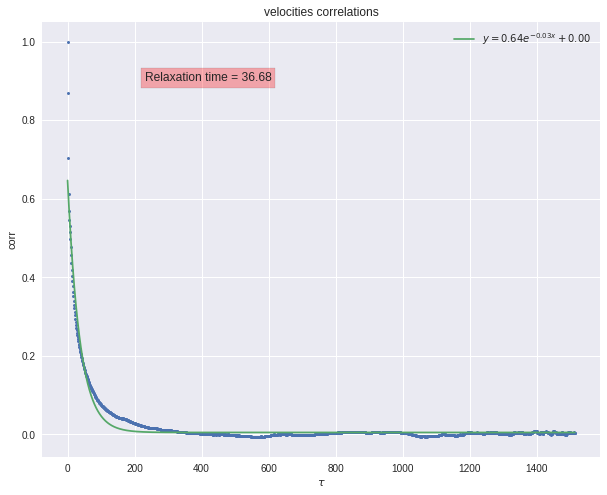

In [8]:
import matplotlib.pyplot as plt
import scipy as scipy
from scipy import optimize
from math import ceil 
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b

x_array=array(range(0,np.shape(corr)[0]))
popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, x_array,corr, p0=[1,-0.5, 1])
plt.figure(figsize=(10,8))
plt.style.use('seaborn')
plt.plot(corr,'o',ms=3)
plt.plot(x_array,exponential(x_array,popt_exponential[0],popt_exponential[1],popt_exponential[2]),label='$y=%.2fe^{%.2f x}+%.2f$'%(popt_exponential[0],popt_exponential[1],popt_exponential[2]))
plt.xlabel('$\\tau$')
plt.ylabel('corr')
plt.title('velocities correlations')
plt.text(230,0.9,'Relaxation time = %0.2f'%(-1/popt_exponential[1]),fontsize=12,bbox=dict(facecolor='red', alpha=0.3))
plt.legend()
plt.savefig('corr vs t.png')
plt.show()

relax_time=ceil(-1/popt_exponential[1])


#Energy

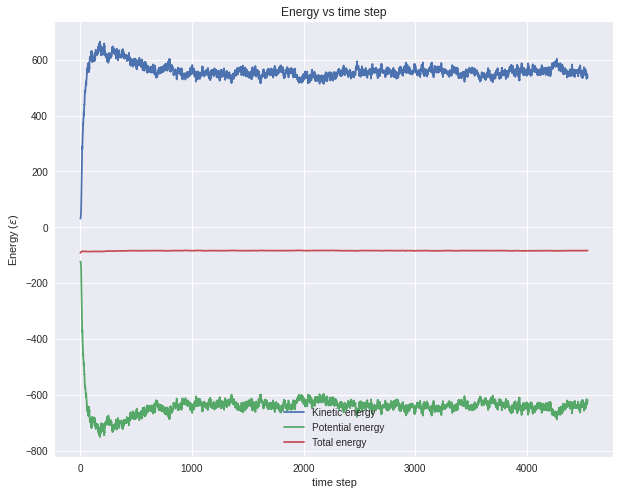

In [9]:
from numpy import genfromtxt
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.figure(figsize=(10,8))
plt.plot(K_list,label='Kinetic energy')
plt.plot(U_list,label='Potential energy')
plt.plot(E,label='Total energy')
plt.xlabel('time step')
plt.ylabel('Energy ($\epsilon$)')
plt.title('Energy vs time step')
plt.legend()
plt.savefig('Energy vs time.png',bbox_inches='tight')

#Temprature

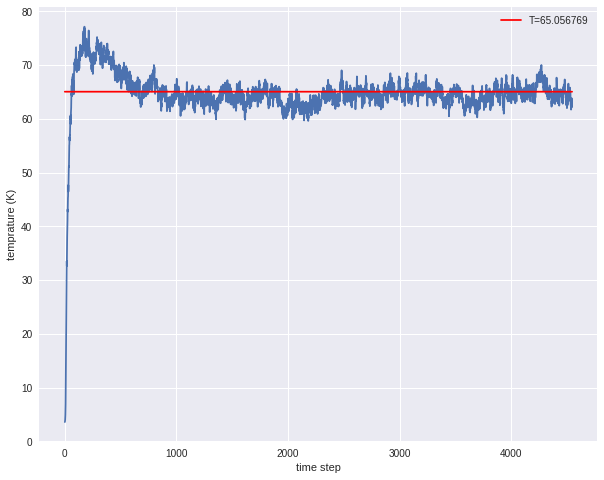

In [10]:
from scipy.constants import k
from math import ceil 

N=1000

epsilon=1.6*10.0**(-21)
temprature=(K_list*1.6*10.0**(-21))/((N-1)*k)
plt.figure(figsize=(10,8))
plt.plot(temprature)
plt.plot([np.mean((K_list[relax_time:]*1.6*10.0**(-21))/((N-1)*k))]*np.shape(K_list)[0],color='r',label='T=%f'%np.mean((K_list[relax_time:]*1.6*10.0**(-21))/((N-1)*k)))
plt.xlabel('time step')
plt.ylabel('temprature (K)')
plt.legend()
plt.savefig('Temprature vs t.png',bbox_inches='tight')

#Pressure

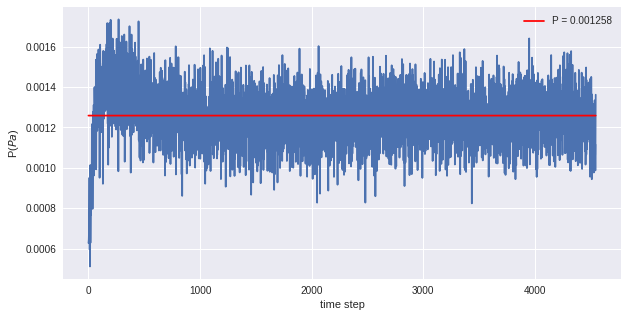

In [11]:
sigma=3.4*10.0**(-10)
L=3*int(np.sqrt(N))
pressure=(N*k*temprature-(1/2)*virial*1.6*10.0**(-21))/(L*L*sigma*sigma)
plt.figure(figsize=(10,5))
plt.plot(pressure)
plt.plot([np.mean(pressure[relax_time:])]*np.shape(pressure)[0],color='r',label="P = %f"%np.mean(pressure[relax_time:]))
plt.xlabel('time step')
plt.ylabel('P($Pa$)')
plt.legend()
plt.savefig('Pressure vs t.png',bbox_inches='tight')

# Number of particles in the left side of the box 

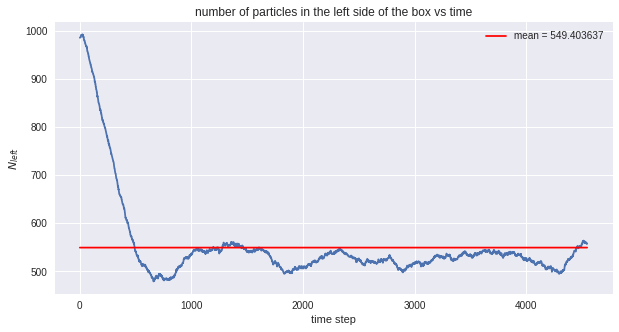

In [12]:
plt.figure(figsize=(10,5))
plt.title('number of particles in the left side of the box vs time')
plt.plot(N_left)
plt.plot([np.mean(N_left[relax_time:])]*np.shape(N_left)[0],color='r',label='mean = %f'%np.mean(N_left[relax_time:]))
plt.xlabel('time step')
plt.ylabel('$N_{left}$')
plt.legend()
plt.savefig('N left')